In [ ]:
!pip install --upgrade cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.4 MB 7.5 MB/s 


In [ ]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc


rc('animation', html='jshtml')

In [ ]:
print(cp.__version__)

1.2.1


In [ ]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [ ]:
import math
print(math.pi)
print(math.exp(1))

3.141592653589793
2.718281828459045


# Setting and Hyperparameters

In [ ]:
valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

utility_type = "linear"
coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/coef_hist_{utility_type}_fisher.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/intercept_hist_{utility_type}_fisher.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/values_hist_{utility_type}_fisher.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_linear = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_linear = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_linear = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_linear = np.load(f)


utility_type = "leontief"
coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/coef_hist_{utility_type}_fisher.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/intercept_hist_{utility_type}_fisher.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/values_hist_{utility_type}_fisher.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_leontief = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_leontief = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_leontief = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_leontief = np.load(f)


utility_type = "cd"
coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/coef_hist_{utility_type}_fisher.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/intercept_hist_{utility_type}_fisher.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/values_hist_{utility_type}_fisher.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_cd = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_cd = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_cd = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_cd = np.load(f)

Mounted at /content/drive


In [ ]:
print(coef_hist_linear[-1])
print(intercept_hist_linear[-1])

[4.46387049 4.88846439]
762.7325996584606


# Library

## utilities

In [ ]:
################### Utility Functions ##########################
def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1) 
    return util

# def get_cd_util(demands, valuations):
#     val_sum = np.sum(valuations)
#     normalized_vals = valuations / val_sum
#     util = np.sum(np.log(demands)*valuations, axis = 1) 
#     return util

def get_cd_util(demands, valuations):
    normalized_vals = valuations / val_sum
    util = np.prod(np.power(demands, normalized_vals), axis = 1)
    return util

def get_cd_util_single(demand, valuation):
    normalized_val = valuation / val_sum
    util = np.prod(np.power(demand, normalized_val))
    return util

#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return ( valuations / allocations.clip(min = 0.001) )


# ################### Min-Max Objective Functions ##########################

# def get_linear_obj(prices, demands, budgets, valuations):
#   utils = np.sum(valuations * demands, axis = 1)
#   return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


# def get_leontief_obj(prices, demands, budgets, valuations):
#     utils = np.min(demands/valuations, axis = 1)
#     return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


# def get_cd_obj(prices, demands, budgets, valuations):
#     utils = np.prod(np.power(demands, valuations), axis= 1)
#     return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


### JAX

In [ ]:
from jax import device_put
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

#### Linear

In [ ]:
def get_linear_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(valuations * demands, axis = 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_linear_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_linear_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[2.0,2.1],[2.2,2.3]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_linear_value = grad(jit(get_linear_value), argnums=1)
savings_grad_linear_value = grad(jit(get_linear_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


spendings = budgets - savings
utils = get_linear_util(demands, valuations).clip(min = 0.01)
marginals = get_linear_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

126.47856
___________________JAX___________________
[[1.8837347 2.96311  ]
 [2.9374995 1.5336959]]
[-4.7255883 -5.0320253]
___________________BY HAND___________________
[[1.8837347 2.96311  ]
 [2.9374995 1.5336959]]
[-4.7255883 -5.0320253]


#### Leontief

In [ ]:
def get_leontief_obj(prices, demands, budgets, valuations):
  utils = jnp.min(demands/valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils))

def get_leontief_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_leontief_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[1.2,2],[0.31, 2.31]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_leontief_value = grad(jit(get_leontief_value), argnums=1)
savings_grad_leontief_value = grad(jit(get_leontief_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_leontief_util(demands, valuations).clip(min = 0.01)
marginals = get_leontief_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

-49.46267
___________________JAX___________________
[[ 8.324999  0.      ]
 [32.225807  0.      ]]
[2.8749387 4.9791827]
___________________BY HAND___________________
[[ 0.        5.292443]
 [22.170336  0.      ]]
[2.8749387 4.6051702]


#### CD

In [ ]:
val_sum=np.sum(valuations)

In [ ]:
def get_cd_obj(prices, demands, budgets, valuations):
  normalized_vals = valuations / val_sum
  utils = jnp.prod(jnp.power(demands, normalized_vals), axis= 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_cd_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_cd_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[0.58332625, 0.7736752 ],
 [0.8184732,  0.5077449 ]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_cd_value = grad(jit(get_cd_value), argnums=1)
savings_grad_cd_value = grad(jit(get_cd_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_cd_util(demands, valuations).clip(min = 0.01)
marginals = get_cd_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

25.352663
___________________JAX___________________
[[2.9539237 3.5033221]
 [4.4601374 3.7537787]]
[0.16258979 0.20250894]
___________________BY HAND___________________
[[428.5654  508.27405]
 [673.4459  566.79126]]
[0.16258982 0.20250896]


## get_max

In [ ]:
val_sum = np.sum(valuations)

In [ ]:
############# Projection onto affine positive half-space, i.e., budget set ###############
def project_to_bugdet_set(X, p, b):
    X_prec = X
    while (True): 
        X -= ((X @ p - b).clip(min= 0)/(np.linalg.norm(p)**2).clip(min= 0.01) * p)
        X = X.clip(min = 0)
        if(np.linalg.norm(X - X_prec) <= np.sum(X_prec)*0.05):
            break
        # print(f"Current iterate {X}\nPrevious Iterate {X_prec}")
        X_prec = X
    return X

In [ ]:

def get_max_linear(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budget = saving + 9.5
    obj = cp.Maximize(valuation.T @ allocation + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)

def get_max_leontief(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budget = saving + 9.5
    obj = cp.Maximize(cp.min(allocation / valuation) + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)

def get_max_cd(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budget = saving + 9.5
    normalized_val = valuation / val_sum
    obj = cp.Maximize(normalized_val.T @ cp.log(allocation) + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value
    value = get_cd_util_single(demand, normalized_val) + gamma*(slope*(saving+9.5)+intercept)

    return (value, demand, saving)

def get_max_cd_1(b, valuation, p, gamma, slope, intercept, num_iter=30, learn_rate=0.005):
  demand = np.array([0.1, 0.1])
  normalized_val = valuation / val_sum
  for i in range(num_iter):
    util = get_cd_util_single(demand, normalized_val)
    demand = demand + learn_rate * (util * normalized_val/demand - p)
    print(demand)
    print(util)
    print(normalized_val/demand)
    print("_________________________________________________")
    demand = project_to_bugdet_set(demand, p, b)
    # print(demand)
  saving = b- demand @ p
  next_budget = saving + 9.5
  value = get_cd_util_single(demand, normalized_val) + gamma * (slope * next_budget + intercept)
  return  value, demand, saving

In [ ]:
p = np.array([9.59586069, 7.92277136])
util, demand, saving = get_max_cd(9.5, valuations[0], p, 0.9, 0.01, 0)
print(demand)
print(util)
print(saving)

util, demand, saving = get_max_cd_1(9.5, valuations[0], p, 0.9, 0.01, 0)
print(demand)
print(util)
print(saving)

[0.3847573  0.73306704]
1.0834828239705279
2.7789841539060944e-09
[0.06057365 0.07383992]
0.9917472988185777
[2.84748536 3.67436318]
_________________________________________________
[0.02669497 0.05242135]
0.990391050328982
[6.46123931 5.1756527 ]
_________________________________________________
[0.0106507  0.03838845]
0.9885112140890049
[16.19447726  7.06761343]
_________________________________________________
[0.04255593 0.03363789]
0.9865650391188293
[4.05308041 8.06574639]
_________________________________________________
[0.01460271 0.03387653]
0.9881911298956181
[11.81168081  8.00892839]
_________________________________________________
[0.02489806 0.03377589]
0.9867291335698307
[6.92755202 8.03279258]
_________________________________________________
[0.01112214 0.03382231]
0.9874593866499027
[15.5080457   8.02176656]
_________________________________________________
[0.03962463 0.0337698 ]
0.9863499461527052
[4.35291334 8.03424033]
___________________________________________

## min-max step

In [ ]:
def min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False):
  prices =np.zeros(valuations.shape[1]).clip(min = 10)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_value = get_linear_value
      demands_grad = demands_grad_linear_value
      savings_grad = savings_grad_linear_value

  elif utility_type == "leontief":
      get_value = get_leontief_value
      demands_grad = demands_grad_leontief_value
      savings_grad = savings_grad_leontief_value

  elif utility_type == "cd":
      get_value = get_cd_value
      demands_grad = demands_grad_cd_value
      savings_grad = savings_grad_cd_value

  prices_step_sizes = []
  demands_step_sizes= []
  savings_step_sizes = []
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0.001,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 1.0)
    savings = np.zeros(num_buyers).clip(min = 0)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      spendings = budgets - savings
      
      # Demand step
      demands_step = demands_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      demands += (iter_inner** (-1/2)) * learn_rate_demands * demands_step
      demands_step_sizes.append(np.linalg.norm(demands_step))
      # print("__________________________________________________")
      # print(demands)
      
      # Saving step
      savings_step = savings_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      savings += (iter_inner** (-1/2)) * learn_rate_demands * savings_step
      savings_step_sizes.append(np.linalg.norm(savings_step))


      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = np.array(savings)
      X.value = np.array(demands)

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.MOSEK, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"demands steps: {demands_step}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)
      # print(demands)

     

    assert np.all(demands @ prices + savings <= budgets + 10e-2)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands) < 1e-2:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands))
      break
    
    # prices += (iter_outer**(-1/2))* learn_rate_prices * excess_demands
    prices +=  learn_rate_prices * excess_demands
    prices_step_sizes.append(np.linalg.norm(excess_demands))
    prices = np.clip(prices, a_min=0.001, a_max = None)
    if test:
      print(prices)

  next_budgets = savings + np.array([9.5, 9.5])
  value = get_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  if test:
    return prices_step_sizes, demands_step_sizes, savings_step_sizes
  else:
    return value, prices, demands, savings

### Test min-max step

1.4142135623730951
1.4
0.05
[9.16360502 9.16360502]
[8.37944844 8.37944844]
[7.65383957 7.65383957]
[6.99316842 6.99316842]
[6.40343399 6.40343399]
[5.88944538 5.88944538]
[5.4538745 5.4538745]
[5.09629589 5.09629589]
[4.81265367 4.81265367]

****Min-Max Price Iteration 10****
[4.59539605 4.59539605]
[4.43443249 4.43443249]
[4.31868011 4.31868011]
[4.23748659 4.23748659]
[4.18162892 4.18162892]
[4.14376359 4.14376359]
[4.11836166 4.11836166]
[4.10144655 4.10144655]
[4.09023871 4.09023871]
Early end! Excess demand norm: 0.00747474653430516
------------------------------------------------------------------
budgets: [9.5 9.5]
demands: [[0.49735728 0.49735728]
 [0.49735728 0.49735728]]
prices: [4.09023871 4.09023871]
value: -74.906075
excess demands: [-0.00528544 -0.00528544]


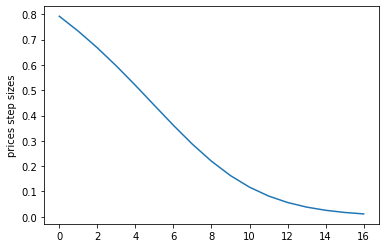

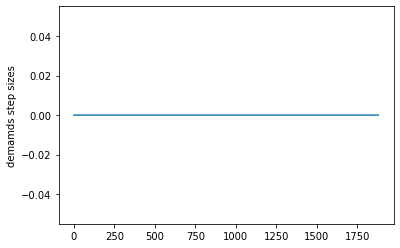

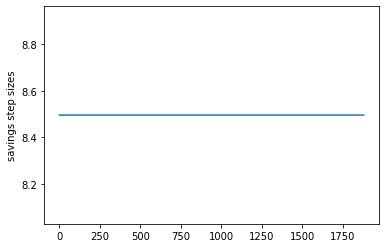

In [ ]:
num_goods = 2
num_buyers = 2
num_samples = 25
discount = 0.9

valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])




num_iters_prices = 60 #30
num_iters_demands = 100

value_coef = np.array([-1, -1])
value_intercept = 0


budgets = np.array([9.5, 9.5])


utility_type = "cd"

# negative big 
# positive small

print(np.linalg.norm(value_coef))

learn_rate_prices = 1.4
# learn_rate_prices = (np.sum(budgets) / 1) * learn_rate_prices_cd * (1 / (np.linalg.norm(value_coef)/15+12))
learn_rate_demands = 0.05
# learn_rate_demands = (np.sum(budgets) / 800) * learn_rate_prices_cd * (1 / (np.linalg.norm(value_coef)/15+12))
print(learn_rate_prices)
print(learn_rate_demands)
# prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_cvx_project(budgets, valuations, value_coef, value_intercept, 
#                                                                                  discount, learn_rate_prices, learn_rate_demands, 
#                                                                                 num_iters_prices, num_iters_demands, utility_type)

prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                 discount, learn_rate_prices, learn_rate_demands, 
                                                                                num_iters_prices, num_iters_demands, utility_type, test=True)
plt.plot(prices_step_sizes[1:])
plt.ylabel("prices step sizes")
plt.show()

plt.plot(demands_step_sizes[1:])
plt.ylabel("demamds step sizes")
plt.show()

plt.plot(savings_step_sizes[1:])
plt.ylabel("savings step sizes")
plt.show()

## single_buyer_val_iter

In [ ]:
def single_buyer_val_iter(budgets_samples, prices_list, buyer, valuations, gamma, slope, intercept, 
                          num_iters, num_samples, utility_type, fitted_value_coef, fitted_value_intercept):
    value_slope_hist = []
    value_intercept_hist = []
    values_hist = []
    budgets_hist = []

    if utility_type == "linear":
        get_max = get_max_linear
    elif utility_type == "leontief":
        get_max = get_max_leontief
    elif utility_type == "cd":
        get_max = get_max_cd_1

    value_slope = slope
    value_intercept = intercept
    value_slope_hist.append(value_slope)
    value_intercept_hist.append(value_intercept)
    num_buyers = valuations.shape[0]
    

    for iter in range(num_iters):
        print(f"-----------------------Iteration {iter}-------------------")
        values = []
        budget_list = []
        for index, budgets in enumerate(budgets_samples):
          print(f"___sample {index}___")
          if buyer == 1:
            value, demand, saving = get_max(budgets[0], valuations[0], prices_list[index], discount, value_slope, value_intercept)
          else:
            value, demand, saving = get_max(budgets[1], valuations[1], prices_list[index], discount, value_slope, value_intercept)
          values.append(value)
          if buyer == 1:
            budget_list.append(budgets[0])
          else:
            budget_list.append(budgets[1])
          print("buyer value:", value)
          print("buyer demands:", demand)


        values_hist.append(values)    
        budgets_hist.append(budget_list)
        print(budget_list)
        print(values)
        reg = linear_model.LinearRegression()
        reg.fit(np.array(budget_list).reshape(-1,1), np.array(values))
        value_slope = reg.coef_[0] # Update the slope
        value_intercept = reg.intercept_ # Update the intercept
        
        value_intercept_hist.append(value_intercept)
        value_slope_hist.append(value_slope)
        values_hist.append(values)
        budgets_hist.append(budgets)
        print("SLOPE", value_slope)
        print("INTERCEPT:", value_intercept)
    
    return value_slope, value_intercept, values_hist



## get_greedy_action

In [ ]:
def get_greedy_action(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                           learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands):
  value, prices, demands, savings =  min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False)

  return (prices, demands, savings)

## get_buyers_cumulative_util

In [ ]:
def get_buyers_cumulative_util(init_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                               num_iters_prices, num_iters_demands, num_iters):
  
  if utility_type == "linear":
      get_util = get_linear_util
  elif utility_type == "leontief":
      get_util = get_leontief_util
  elif utility_type == "cd":
      get_util = get_cd_util
  

  num_buyers = valuations.shape[0]
  num_goods = valuations.shape[1]
  cumul_utils = np.zeros(num_buyers)
  excess_demands_hist = []
  budgets = init_budgets   
  for iter in range(num_iters):
    print(f"--------------------cumulative iter {iter}---------------------")
    print(f"budgets: {budgets}")
    prices, demands, savings = get_greedy_action(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                           learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands)
    if iter == 0:
      start_prices = prices
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    excess_demands_hist.append(np.linalg.norm(excess_demands))
    print("util:", get_util(demands, valuations))
    cumul_utils += (discount**iter)*get_util(demands, valuations)
    budgets = savings + np.array([9.5,9.5])

  return cumul_utils, excess_demands_hist


# Changes in Value Functions

## Plot

[[ 1.          1.        ]
 [-2.86323962 -3.16103848]
 [-2.86371676 -3.15782195]
 [-2.86372273 -3.15782911]
 [-2.86372272 -3.15782854]
 [-2.86370705 -3.15782975]
 [-2.86371879 -3.15782896]
 [-2.86372683 -3.15784447]
 [-2.86369447 -3.15783512]
 [-2.8637193  -3.15781617]
 [-2.86369571 -3.15782938]
 [-2.86371698 -3.15782645]
 [-2.86371648 -3.15784534]
 [-2.86370562 -3.15783044]
 [-2.86370645 -3.15782363]
 [-2.86372859 -3.15782642]
 [-2.86370537 -3.15783525]
 [-2.86370944 -3.15782337]
 [-2.86370964 -3.15783645]
 [-2.86372459 -3.15782503]
 [-2.86369358 -3.15783428]
 [-2.86369305 -3.15783273]
 [-2.86371221 -3.15784776]
 [-2.86370888 -3.15782847]
 [-2.86373833 -3.15782616]
 [-2.86370666 -3.15784425]
 [-2.86371231 -3.15782986]
 [-2.86370285 -3.15781883]
 [-2.86374609 -3.15782716]
 [-2.86374474 -3.1578161 ]
 [-2.86375999 -3.15782992]]


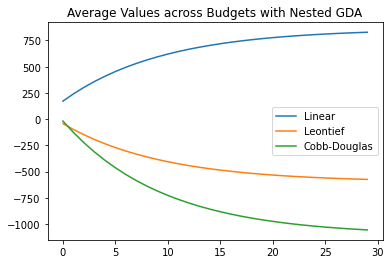

In [ ]:
avg_values_linear = np.average(values_hist_linear, axis = 1) 
# avg_values_linear = avg_values_linear / np.sum(avg_values_linear)
avg_values_leontief = np.average(values_hist_leontief, axis = 1)
# avg_values_leontief = avg_values_leontief/ np.sum(avg_values_leontief)
avg_values_cd = np.average(values_hist_cd, axis = 1)
# avg_values_cd= avg_values_cd / np.sum(avg_values_cd)

fig, ax = plt.subplots()
ax.set_title('Average Values across Budgets with Nested GDA')
ax.plot(np.arange(0, avg_values_linear.shape[0]), avg_values_linear, label = "Linear")
ax.plot(np.arange(0, avg_values_leontief.shape[0]), avg_values_leontief, label = "Leontief")
ax.plot(np.arange(0, avg_values_cd.shape[0]), avg_values_cd, label = "Cobb-Douglas")
ax.legend()
fig.show()

print(coef_hist_leontief)

# Distance to Utility Maximization

## Single_buyer_val_iter

In [ ]:
discount = 0.9

slope = 0
intercept = 0

num_iters = 50
num_samples = 15
utility_type = "cd"


budgets = np.array([10,10])
fitted_value_coef = np.array([0.65690774, 0.67843907])
fitted_value_intercept = 110.44224773100474
print(fitted_value_coef)
print(fitted_value_intercept)
learn_rate_prices = 1
learn_rate_demands = 1
num_iters_prices = 60 #30
num_iters_demands = 100


[0.65690774 0.67843907]
110.44224773100474


##### Get budgets-prices pairs for value iterations

In [ ]:
num_buyers = valuations.shape[0]
budgets_samples = np.random.uniform(9, 10, (num_samples, num_buyers))
prices_list = []
learn_rate_prices = 1.4
learn_rate_demands = 0.005
for index, budgets in enumerate(budgets_samples):
    print(f"-------------------------Sample {index}--------------------------------")
    min_max_value, prices, demands, savings = min_max_linear_value_jax(budgets, valuations, fitted_value_coef, fitted_value_intercept, discount, 
                                                                      learn_rate_prices, learn_rate_demands,
                                                                      num_iters_prices, num_iters_demands, utility_type, test=False)
    prices_list.append(prices)

print(prices_list)

-------------------------Sample 0--------------------------------

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.00959072275063612
------------------------------------------------------------------
budgets: [9.27029411 9.27421743]
demands: [[0.423289   0.57539673]
 [0.57274951 0.41586893]]
prices: [9.61439384 8.96992577]
value: 123.26527
excess demands: [-0.00396149 -0.00873433]
-------------------------Sample 1--------------------------------

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.008764651008008066
------------------------------------------------------------------
budgets: [9.08947317 9.29444315]
demands: [[0.41821773 0.57005967]
 [0.57778107 0.42214229]]
prices: [9.53534777 8.87941599]
value: 123.15634
excess demands: [-0.0040012  -0.00779804]
-------------------------Sample 2--------------------------------

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.009952222607072196
-------------------------------------

##### Single buyer value iteration

In [ ]:
slope = 0
intercept = 0
learned_slopes = []
learned_intercepts = []
cumul_utils_single = []
values_hists = []

for buyer in [1,2]:
  opt_value_slope, opt_value_intercept, values_hist = single_buyer_val_iter(budgets_samples, prices_list, buyer, valuations, discount, slope, intercept, num_iters, num_samples, 
                                                                                            utility_type, fitted_value_coef, fitted_value_intercept)
  print(f"cumul util: {opt_value_slope * budgets[buyer-1] + opt_value_intercept}")
  print(f"slope: {opt_value_slope}")
  print(f"intercept: {opt_value_intercept}")
  cumul_utils_single.append(opt_value_slope * budgets[buyer-1] + opt_value_intercept)
  values_hists.append(values_hist)
  learned_slopes.append(opt_value_slope)
  learned_intercepts.append(opt_value_intercept)

Streaming output truncated to the last 5000 lines.
buyer demands: [0.37047832 0.6258107 ]
___sample 2___
buyer value: 0.7473458445029333
buyer demands: [0.37783663 0.63467514]
___sample 3___
buyer value: 0.7382709663995318
buyer demands: [0.36660059 0.61848681]
___sample 4___
buyer value: 0.7525970352611578
buyer demands: [0.38390527 0.64470372]
___sample 5___
buyer value: 0.7393808898142612
buyer demands: [0.36754426 0.6209053 ]
___sample 6___
buyer value: 0.7392131073576288
buyer demands: [0.36715177 0.62080768]
___sample 7___
buyer value: 0.7576503652611571
buyer demands: [0.39018819 0.65401889]
___sample 8___
buyer value: 0.7546370931618638
buyer demands: [0.38641863 0.64847266]
___sample 9___
buyer value: 0.7449318451331056
buyer demands: [0.37414325 0.63108056]
___sample 10___
buyer value: 0.7443071699459273
buyer demands: [0.37344191 0.62988312]
___sample 11___
buyer value: 0.7443047923073594
buyer demands: [0.37444985 0.6287973 ]
___sample 12___
buyer value: 0.7385931017592596


##### Cumulative utils single

[7.43050425 6.91734706]


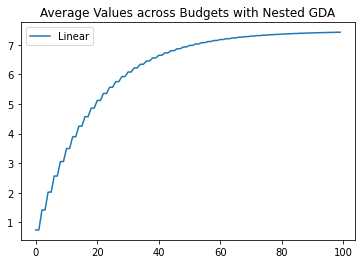

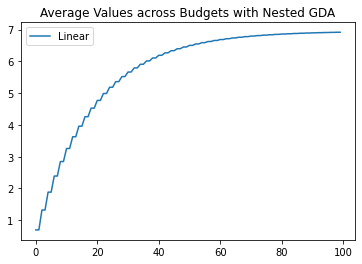

In [ ]:
print(np.array(cumul_utils_single))

for values_hist in values_hists:
  avg_values = np.average(values_hist, axis = 1) 
# avg_values_linear = avg_values_linear / np.sum(avg_values_linear)


  fig, ax = plt.subplots()
  ax.set_title('Average Values across Budgets with Nested GDA')
  ax.plot(np.arange(0, avg_values.shape[0]), avg_values, label = "Linear")
  ax.legend()
  fig.show()

## Cumul_util both buyers

In [ ]:
init_budgets = np.array([10, 10])
print(fitted_value_coef)
print(fitted_value_intercept)
num_iters_prices = 60
num_iters_demands = 100
num_iters = 50
discount = 0.9
learn_rate_prices = 1.4
learn_rate_demands = 0.005
utility_type = "cd"
cumul_utils, excess_demands_hist =  get_buyers_cumulative_util(init_budgets, valuations, utility_type, fitted_value_coef, fitted_value_intercept, discount, learn_rate_prices, learn_rate_demands,
                               num_iters_prices, num_iters_demands, num_iters)

[0.65690774 0.67843907]
110.44224773100474
--------------------cumulative iter 0---------------------
budgets: [10 10]

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.008757543151556205
------------------------------------------------------------------
budgets: [10 10]
demands: [[0.42444177 0.58010285]
 [0.581144   0.41315224]]
prices: [10.28809818  9.64346781]
value: 124.19221
excess demands: [ 0.00558577 -0.0067449 ]
util: [0.74411581 0.69282634]
--------------------cumulative iter 1---------------------
budgets: [9.53909643 9.53691167]

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.009859420055901458
------------------------------------------------------------------
budgets: [9.53909643 9.53691167]
demands: [[0.42302947 0.57647049]
 [0.57499767 0.41386949]]
prices: [9.87655739 9.23153452]
value: 123.62002
excess demands: [-0.00197286 -0.00966002]
util: [0.74242184 0.69036813]
--------------------cumulative iter 2---------------------
budget

In [ ]:
print(excess_demands_hist)
print(np.mean(excess_demands_hist))

[0.008757543151556205, 0.009859420055901458, 0.009855947546790906, 0.00985578603309946, 0.009855786218790706, 0.009855786472551824, 0.009855786472685637, 0.00985578647269426, 0.00985578647268723, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.009855786472690703, 0.0098557864

In [ ]:
print(cumul_utils)

[7.38764078 6.87059188]


## Results

In [ ]:
cumul_utils = np.array([7.38764078, 6.87059188])
cumul_utils_single = np.array([7.43050425, 6.91734706])

In [ ]:
print(np.linalg.norm(cumul_utils-cumul_utils_single))
print(np.linalg.norm(cumul_utils-cumul_utils_single) / np.linalg.norm(cumul_utils_single))

0.06342967694441869
0.006248029048292649


## Make the table

In [ ]:
import plotly.graph_objects as go

headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Utility Type</b>','<b>Cumulative Utility based on VI</b>','<b>Maximized cumulative Utility</b>',
            '<b>Distance to Utility Maximization</b>','<b>Normalized Distance to Utility Maximization</b>', 
            '<b>Distance to Market Clearance (Average Excess Demands)</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      ['Linear (Nested GDA)', 'Linear (Max-oracle GD)', 'Leontief (Nested GDA)', 'Leontief (Max-oracle GD)', 'Cobb-Douglas (Nested GDA)', 'Cobb-Douglas (Max-oracle GD)'],
      ['[96.11864217, 872.44457586]', 
       '[58.83670238, 65.37844446]', 
       '[0.01241015, 0.01197241]', 
       '[0.0044322, 0.00609951]', 
       '[-759048.31311689, -844533.23523943]', 
       '[-763010.21531314 -847841.51430998]'],
      ['[84.79659719559233, 90.3457392997638]',
       '[96.96171820101995, 106.36975094410113]',
       '[0.009253314180356959, 0.008070244600082384]',
       '[0.012505356366874554, 0.00961266013048025]',
       '[-5410.446761817995, -5757.897160340484]', 
       '[-5482.763563167677, -5790.554467234857]'],
      [782.1807839960541, 55.98038976844064, 
       0.005019216377258324, 0.008804435107563718, 
       1127614.3407095883, 1132650.7224766547],
       [6.312670581380343,0.3889393929909976,
        0.408792752480498,0.5581970083770711,
        142.71734067443717, 142.0356741620785],
      [1.51360722680293,2.1650851972578646,
       2.1885091150520655,2.178489762142351, 
       2.1892506104891303, 2.1697254289647336]],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor,rowEvenColor]*5],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.show()


In [ ]:
util_vi = np.array([0.0044322, 0.00609951])
util_single = np.array( [0.012505356366874554, 0.00961266013048025])
print(np.linalg.norm(util_vi-util_single))
print(np.linalg.norm(util_vi-util_single) / np.linalg.norm(util_single))

0.008804435107563718
0.5581970083770711


## Make the Bar Plot

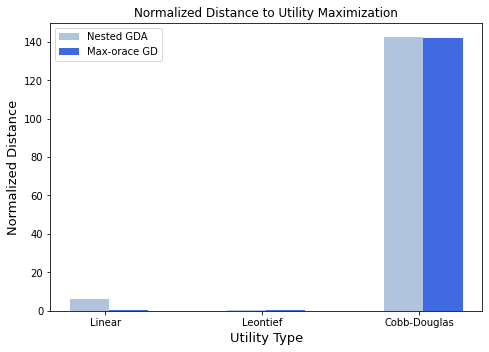

In [ ]:
data = [[6.312670581380343,0.408792752480498,142.71734067443717,],
[0.3889393929909976,0.5581970083770711,142.0356741620785]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Normalized Distance to Utility Maximization')
ax.bar(X + 0.00, data[0], color = 'lightsteelblue', width = 0.25, label ='Nested GDA')
ax.bar(X + 0.25, data[1], color = 'royalblue', width = 0.25, label ='Max-orace GD')

plt.xlabel('Utility Type', fontsize = 13)
plt.xticks([r + 0.1 for r in range(3)],
        ['Linear', 'Leontief', 'Cobb-Douglas'])
plt.ylabel('Normalized Distance', fontsize = 13)


plt.legend()
plt.show()

# Distance to Market Clearance

In [ ]:
excess_demands_linear_cvx = np.array([1.007923199446748, 0.011324849082771498, 0.011398197315511347, 0.011431693362778687, 0.011514927297107215, 0.01157807542950712, 0.011618352406576533, 0.011679292163442259, 0.011766210726685216, 0.30914232888117826, 2.2360644706166517, 2.2360648322261607, 2.236064444420647, 2.2360666169808168, 2.2360638937796753, 2.2360653979793996, 2.23606707800732, 2.236067013359693, 2.2360665546967753, 2.236061975729724, 2.2360672219546243, 2.23606755935085, 2.2360675492441127, 2.2360658551356996, 2.2360676760900065, 2.236067971670458, 2.2360669689675574, 2.2360469023876464, 2.2360624685748447])
excess_demands_leontief_cvx = np.array([0.9293471161358905, 2.188377777310114, 2.229028680982791, 2.2315775449161825, 2.2327239919492086, 2.2335727449365246, 2.2342056502220706, 2.234674796050045, 2.2350239910558742, 2.235279193011836, 2.2354710987066877, 2.235620769377735, 2.235726979420378, 2.2358152237564304, 2.2358752833842446, 2.235923677364442, 2.235959152434828, 2.2359960362954117, 2.236017831284798, 2.236032348195055, 2.2360419838953502, 2.2360495106489986, 2.2360543575158216, 2.2360577367925876, 2.2360600743323733, 2.2360620043457797, 2.2360618811860014, 2.236063053510682, 2.236063847491746])
excess_demands_cd_cvx = np.array([0.878369719707621, 2.236067847485999, 2.2360677299612814, 2.236067670026975, 2.236067646686249, 2.236067924533268, 2.2360676432399735, 2.2360679257193556, 2.2360676419982752, 2.2360679249417434, 2.2360676417874736, 2.236067924783226, 2.2360676417662018, 2.2360679246573407, 2.2360676418047785, 2.236067924852683, 2.236067642098393, 2.2360679249652864, 2.2360676417504823, 2.236067925625168, 2.236067641510322, 2.236067925285582, 2.2360676418598504, 2.2360679253504068, 2.236067923609602, 2.2360676440170857, 2.236067924884247, 2.23606764237371, 2.2360679269021975])

excess_demands_linear_heuristic = np.array([0.17758096980109522, 2.2360679775187116, 2.236054700354538, 2.2360679457155266, 2.236067950605495, 2.2360679537217085, 2.236067955980454, 2.2360679577458273, 2.236067959219619, 2.2360679604972664, 2.236067961645776, 2.2360679627171383, 2.236067963738487, 2.2360679647352497, 2.2360679657244362, 2.2360679667155727, 2.2360679677179447, 2.2360679687286, 2.2360679697424453, 2.236067969883648, 2.2360679699314385, 2.236067969960027, 2.236067969963552, 2.236067969943169, 2.236067969893672, 2.2360679698093997, 2.2360679696861667, 2.2360679695112857, 2.236067969269816])
excess_demands_leontief_heuristic = np.array([0.566528032626108, 2.2360679775068184, 2.2358397023466123, 2.236067976285023, 2.236067976461301, 2.236067977015341, 2.2360679764486684, 2.2360679765398452, 2.23606797641845, 2.2360679766418077, 2.2360679764491875, 2.2360679764780214, 2.236067976166385, 2.23606797643746, 2.236067976770492, 2.236067976784724, 2.2360679766305465, 2.236067976559505, 2.236067976658762, 2.2360679766268046, 2.236067977061843, 2.2360679763690956, 2.2360679763690117, 2.236067976502387, 2.236067976476328, 2.236067976011311, 2.236067976486751, 2.236067976671927, 2.236067976327661])
excess_demands_cd_heuristic = np.array([0.3123618740016494, 2.236067977506149, 2.2358401939400605, 2.2360679767090654, 2.2360679766883274, 2.2360679767731315, 2.2360679769866607, 2.2360679761812126, 2.236067976420635, 2.2360679770746184, 2.2360679766684926, 2.236067976645758, 2.2360679769932954, 2.236067977008064, 2.236067976619816, 2.2360679770529246, 2.2360679770358294, 2.2360679767441054, 2.2360679768428526, 2.236067976486209, 2.236067976667855, 2.236067976646691, 2.2360679770109146, 2.236067976624189, 2.236067976637902, 2.2360679763400824, 2.2360679764441302, 2.236067976582384, 2.236067976644269])


EDnorm_linear_cvx = np.mean(excess_demands_linear_cvx)
EDnorm_leontief_cvx = np.mean(excess_demands_leontief_cvx)
EDnorm_cd_cvx = np.mean(excess_demands_cd_cvx)

print(EDnorm_linear_cvx)
print(EDnorm_leontief_cvx)
print(EDnorm_cd_cvx)

EDnorm_linear_heuristic = np.mean(excess_demands_linear_heuristic)
EDnorm_leontief_heuristic = np.mean(excess_demands_leontief_heuristic)
EDnorm_cd_heuristic = np.mean(excess_demands_cd_heuristic)

print("linear_heu", EDnorm_linear_heuristic)
print("leontief_heu", EDnorm_leontief_heuristic)
print("cd_heu", EDnorm_cd_heuristic)


1.51360722680293
2.1885091150520655
2.1892506104891303
linear_heu 2.1650851972578646
leontief_heu 2.178489762142351
cd_heu 2.1697254289647336


### Make the Bar Plot

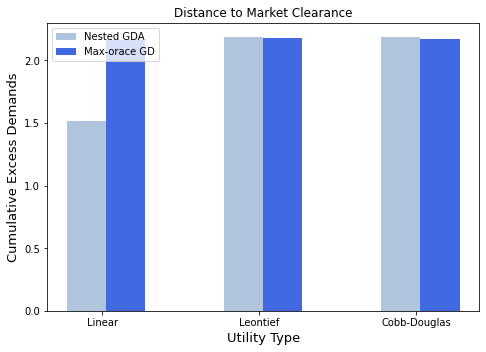

In [ ]:
data = [[1.51360722680293, 2.1885091150520655, 2.1892506104891303],
      [2.1650851972578646,2.178489762142351, 2.1697254289647336]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Distance to Market Clearance')
ax.bar(X + 0.00, data[0], color = 'lightsteelblue', width = 0.25, label ='Nested GDA')
ax.bar(X + 0.25, data[1], color = 'royalblue', width = 0.25, label ='Max-orace GD')

plt.xlabel('Utility Type', fontsize = 13)
plt.xticks([r + 0.1 for r in range(3)],
        ['Linear', 'Leontief', 'Cobb-Douglas'])
plt.ylabel('Cumulative Excess Demands', fontsize = 13)


plt.legend()
plt.show()